In [1]:
from qft import *
from qiskit import qasm2
import pandas as pd

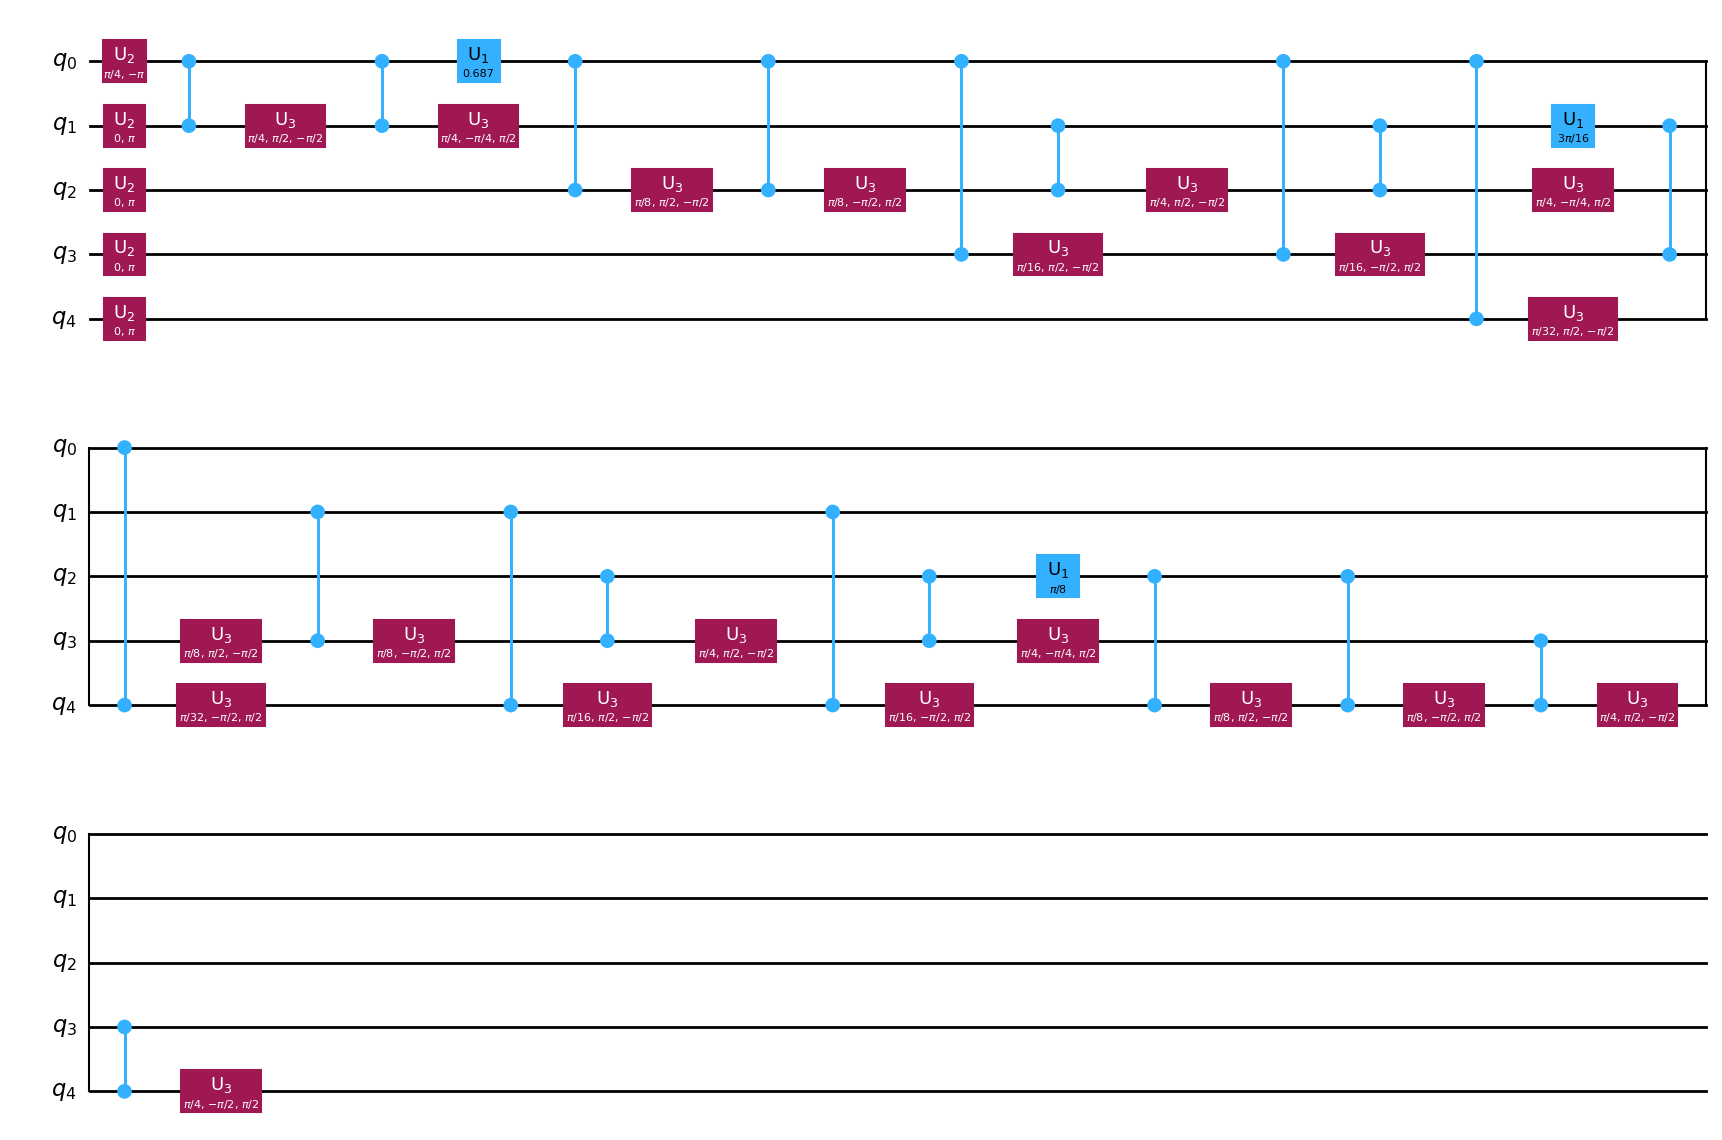

In [2]:
num_q = 20
cir = QFT(num_q)
cir.draw()

In [3]:
def move_time(distance):
    return 200*((distance/110)**(1/2))

In [4]:
import math
def set_parameters(default):
    para = {}
    if default:
        para['T_cz'] = 0.2  #us
        para['T_eff'] = 1.5e6 #us
        para['T_trans'] = 20 # us
        para['AOD_width'] = 3 #um
        para['AOD_height'] = 3 #um
        para['Move_speed'] = 0.55 #um/us
        para['F_cz'] = 0.995
        para['F_transfer'] = 0.999
        para['F_cz_idle'] = 1 - (1-para['F_cz'])/2
        para['R_b'] = 6 #um

    return para
def DasAtom_fidelity(parallel_gates, all_movements, num_q, gate_num):
    para = set_parameters(True)
    t_total = 0
    t_total += (len(parallel_gates) * para['T_cz']) # cz execution time, parallel
    t_move = 0
    for move in all_movements:
        t_total += (4 * para['T_trans']) # pick/drop/pick/drop
        t_move += (4 * para['T_trans'])
        max_dis = 0
        for each_move in move:
            x1, y1 = each_move[1][0],each_move[1][1]
            x2, y2 = each_move[2][0],each_move[2][1]
            dis = (abs(x2-x1)*para['AOD_width'])**2 + (abs(y2-y1)*para['AOD_height'])**2
            if dis > max_dis:
                max_dis = dis
        max_dis = math.sqrt(max_dis)
        t_total += (max_dis/para['Move_speed'])
        t_move += (max_dis/para['Move_speed'])

    t_idle = num_q * t_total - gate_num * para['T_cz']
    Fidelity = math.exp(-t_idle/para['T_eff']) * (para['F_cz']**gate_num)
    move_fidelity = math.exp(-t_move/para['T_eff'])
    return t_idle, Fidelity, move_fidelity

def Enola_fidelity(parallel_gates, all_movements, num_q, gate_num):
    para = set_parameters(True)
    cir_fidelity_1q_gate = 1
    cir_fidelity_2q_gate = 1
    cir_fidelity_2q_gate_for_idle = 1
    cir_fidelity_atom_transfer = 1
    cir_fidelity_coherence = 1
    cir_qubit_idle_time = [0 for _ in range(num_q)]

    # num_gate = sum([len(gates) for gates in parallel_gates])
    cir_fidelity_2q_gate = para['F_cz'] ** gate_num
    cir_fidelity_2q_gate_for_idle = para['F_cz_idle'] ** (2*(len(parallel_gates)-1)*num_q - 2*gate_num)

    for movements in all_movements:
        for mov in movements:
            q = mov[0]
            cir_qubit_idle_time[q] += 4*para['T_trans']
        cir_fidelity_atom_transfer *= para['F_transfer']**(4*len(mov))
        # TODO: only for d = 1
        for i in range(num_q):
            cir_qubit_idle_time[i] += move_time(para['R_b'])
    for t in cir_qubit_idle_time:
            cir_fidelity_coherence *= (1 - t/para["T_eff"])
    res = {"cir_fidelity_1q_gate":cir_fidelity_1q_gate,
            "cir_fidelity_2q_gate": cir_fidelity_2q_gate,
            "cir_fidelity_2q_gate_for_idle":cir_fidelity_2q_gate_for_idle,
            "cir_fidelity_atom_transfer":cir_fidelity_atom_transfer,
            "cir_fidelity_coherence":cir_fidelity_coherence,}
    cir_fidelity = cir_fidelity_1q_gate * cir_fidelity_2q_gate * cir_fidelity_2q_gate_for_idle \
        * cir_fidelity_atom_transfer * cir_fidelity_coherence
    res["cir_fidelity"] = cir_fidelity
    return res


In [5]:
cir.gate_list

[[[0, 1]],
 [[0, 1]],
 [[0, 2]],
 [[0, 2]],
 [[1, 2], [0, 3]],
 [[1, 2], [0, 3]],
 [[1, 3], [0, 4]],
 [[1, 3], [0, 4]],
 [[2, 3], [1, 4]],
 [[2, 3], [1, 4]],
 [[2, 4]],
 [[2, 4]],
 [[3, 4]],
 [[3, 4]]]

In [6]:
maps = cir.LNN_maps()
maps

[[(1, 1), (2, 1), (2, 2), (3, 2), (3, 1)],
 [(2, 1), (1, 1), (2, 2), (3, 2), (3, 1)],
 [(2, 1), (1, 1), (2, 2), (3, 2), (3, 1)],
 [(2, 2), (1, 1), (2, 1), (3, 2), (3, 1)],
 [(2, 2), (1, 1), (2, 1), (3, 2), (3, 1)],
 [(3, 2), (2, 1), (1, 1), (2, 2), (3, 1)],
 [(3, 2), (2, 1), (1, 1), (2, 2), (3, 1)],
 [(3, 1), (2, 2), (1, 1), (2, 1), (3, 2)],
 [(3, 1), (2, 2), (1, 1), (2, 1), (3, 2)],
 [(3, 1), (3, 2), (2, 1), (1, 1), (2, 2)],
 [(3, 1), (3, 2), (2, 1), (1, 1), (2, 2)],
 [(3, 1), (3, 2), (2, 2), (1, 1), (2, 1)],
 [(3, 1), (3, 2), (2, 2), (1, 1), (2, 1)],
 [(3, 1), (3, 2), (2, 2), (2, 1), (1, 1)]]

In [7]:
from Enola.route import *

In [8]:
route = QuantumRouter(num_q,maps,cir.gate_list,[2,2*num_q+1])
route.run()

In [9]:
route.movement_list

[[[[1, (2, 1), (1, 1)]]],
 [[[0, (1, 1), (2, 1)]]],
 [[[1, (1, 1), (2, 1)]]],
 [[[1, (2, 1), (1, 1)]]],
 [[[2, (2, 2), (2, 1)]]],
 [[[0, (2, 1), (2, 2)]]],
 [[[2, (2, 1), (2, 2)]]],
 [[[2, (2, 2), (2, 1)]]],
 [[[3, (3, 2), (2, 2)], [2, (2, 1), (1, 1)]]],
 [[[1, (1, 1), (2, 1)], [0, (2, 2), (3, 2)]]],
 [[[3, (2, 2), (3, 2)], [2, (1, 1), (2, 1)]]],
 [[[3, (3, 2), (2, 2)], [2, (2, 1), (1, 1)]]],
 [[[4, (3, 1), (3, 2)], [1, (2, 1), (2, 2)]]],
 [[[3, (2, 2), (2, 1)], [0, (3, 2), (3, 1)]]],
 [[[4, (3, 2), (3, 1)], [1, (2, 2), (2, 1)]]],
 [[[4, (3, 1), (3, 2)], [1, (2, 1), (2, 2)]]],
 [[[4, (3, 2), (2, 2)], [3, (2, 1), (1, 1)]]],
 [[[2, (1, 1), (2, 1)], [1, (2, 2), (3, 2)]]],
 [[[4, (2, 2), (3, 2)], [3, (1, 1), (2, 1)]]],
 [[[4, (3, 2), (2, 2)], [3, (2, 1), (1, 1)]]],
 [[[4, (2, 2), (2, 1)]]],
 [[[2, (2, 1), (2, 2)]]],
 [[[4, (2, 1), (2, 2)]]],
 [[[4, (2, 2), (2, 1)]]],
 [[[4, (2, 1), (1, 1)]]],
 [[[3, (1, 1), (2, 1)]]],
 [[[4, (1, 1), (2, 1)]]]]

In [15]:
data_list = []
for n in range(5,51):
    cir = QFT(n)
    print(n)
    maps = cir.LNN_maps()
    route = QuantumRouter(cir.num_qubits,maps,cir.gate_list, [12,n/10 + 6])
    route.run()
    route.save_program(f"fold_map/qft_{n}_full_code.json")
    # total_paralled = cir.gate_list
    # all_movements = []
    # for num in range(len(maps) - 1):
    #     for paral_moves in route.movement_list[num]:
    #         all_movements.append(paral_moves)
    # gate_num = cir.num_gate
    # # t_idle, Fidelity, move_fidelity = DasAtom_fidelity(total_paralled, all_movements, n, gate_num)
    # # data = {"bench file": f"qft_{n}.qasm",
    # #         "cir fidelity": Fidelity,
    # #         "idle time": t_idle,
    # #         "move fidelity": move_fidelity}
    # data = Enola_fidelity(total_paralled, all_movements, n, gate_num)
    # data_list.append(data)

5
6
7
8


ValueError: Offload_3:OffloadRow_1:ColShift:Move: col ending position invalid col 2 at x=61 while col 3 at x=42.

In [13]:
data_pd = pd.DataFrame(data_list)
data_pd.to_csv("qft.csv")